# Project 4: Advanced Lane Finding

In [55]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

In [56]:
# prepare object points

def get_points(image_files, nx=9, ny=6):
    objpoints = []
    imgpoints = []

    # Make a list of calibration images
    print("this is image_files: ", image_files)
    
    for image_file in image_files:
        img = cv2.imread(image_file)
        
        # construct object point, this is the same for every 9x6 chessboard
        objpoint = np.zeros((ny*nx,3), np.float32)
        
        # x, y coordinates, leave z coordinate as 0 since it's always 0 on a flat plane
        objpoint[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            objpoints.append(objpoint)
            imgpoints.append(corners)
        else:
            print("ret is false!!")
            # some images have dimensions other than nx=9 and ny=6
    return objpoints, imgpoints


this is image_files:  ['camera_cal/calibration1.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration9.jpg']
ret is false!!
ret is false!!
ret is false!!


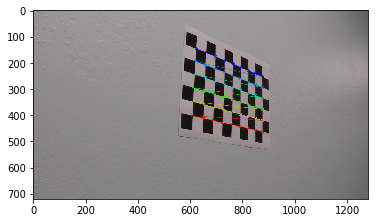

In [57]:
import glob

# feed calibration image files to get objpoints and imgpoints
image_files = glob.glob('camera_cal/calibration*.jpg') # I could also use import os
objpoints, imgpoints = get_points(image_files)

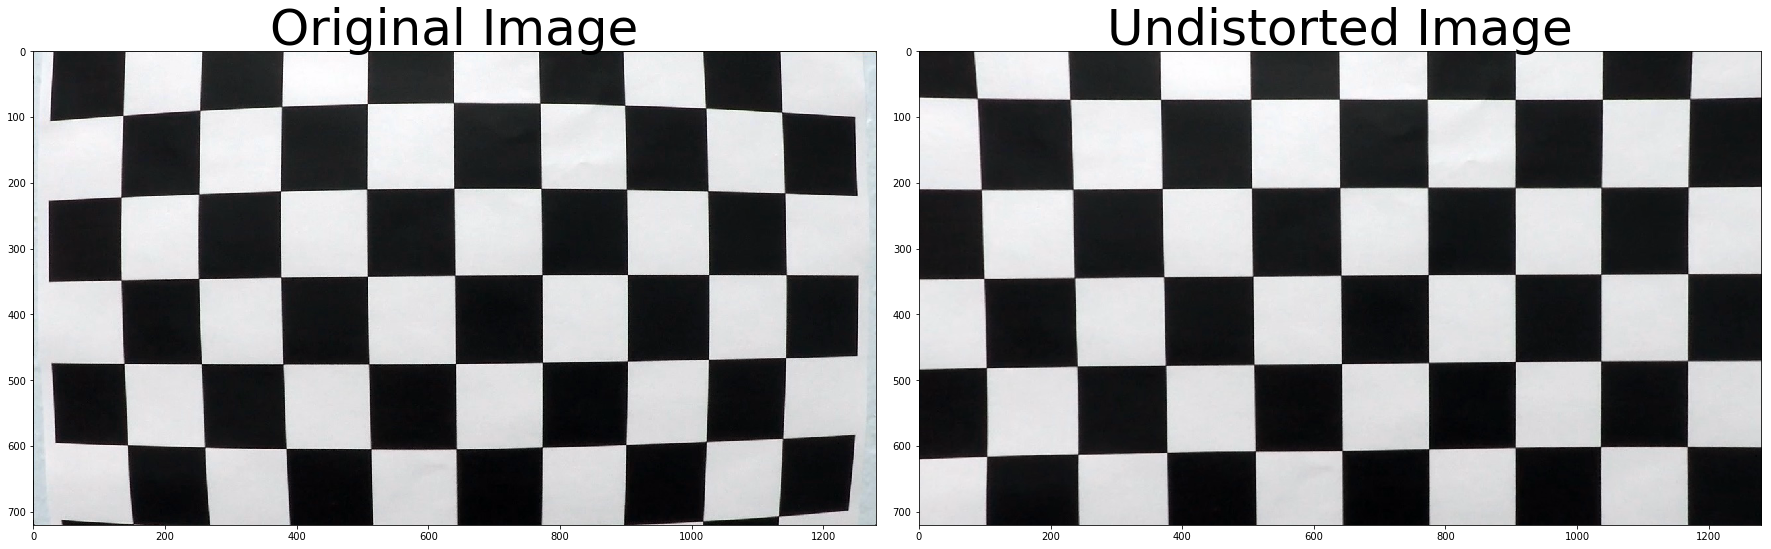

In [59]:
# calibrate camera
# only need to call cv2.calibrateCamera once, save the output variables so they can be reused
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
undist = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)

#use calibration1.jpg as test_image since it has odd dimension (nx=9, ny=5)
test_image = cv2.imread('camera_cal/calibration1.jpg')
undistorted_image, mtx = cal_undistort(test_image, objpoints, imgpoints)

# debugger
# import pdb; pdb.set_trace()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig('output_images/undistort_output.png', dpi=100)

# fig = plt.figure()
# plot = fig.add_subplot(1,2,1)
# plt.imshow(test_image)
# plot.set_title("Distorted")
# plot = fig.add_subplot(1,2,2)
# plt.imshow(undistorted_image)
# plot.set_title("Undistorted")


## Color Transform, Gradients etc

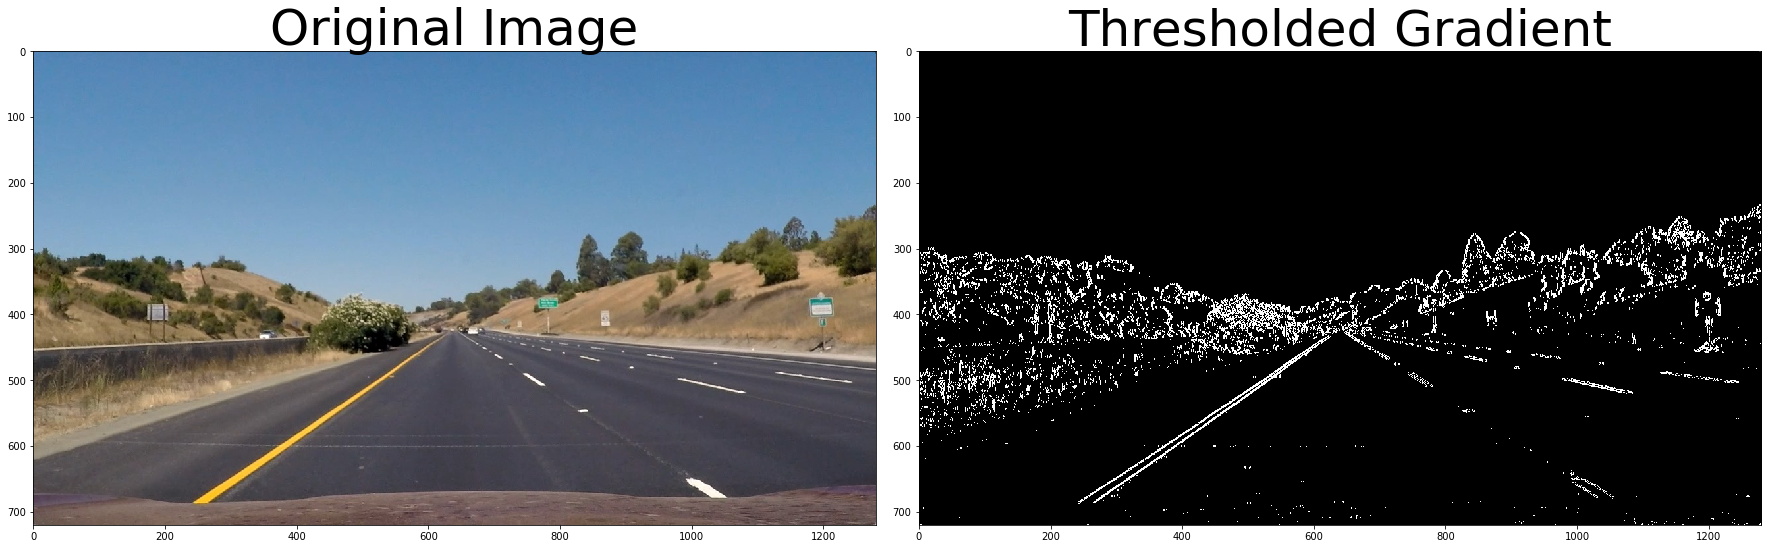

In [117]:
# Gradients
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):    
    # Apply the following steps to img
    # 1) Convert to grayscale, since cv2.Sobel only takes one value in color channel
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'y':
        deriv = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        deriv = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_deriv = np.absolute(deriv)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # scale to 8-bit is just to standardize the pixels in the input image
    scaled_deriv = np.uint8(255*abs_deriv/np.max(abs_deriv))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_deriv)
    binary_output[(scaled_deriv > thresh_min) & (scaled_deriv < thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

image1 = mpimg.imread('test_images/straight_lines1.jpg')

grad_binary = abs_sobel_thresh(image1, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

In [111]:
def warper(img, camera_matrix, distortion_coefficients, source, destination):
    # undistort img first
    undist = cv2.undistort(img, camera_matrix, distortion_coefficients, None, camera_matrix)
    
    # need to convert to grayscale since warpPerspective only takes in one value in the color channel
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    M = cv2.getPerspectiveTransform(source,destination)
    #Minv = cv2.getPerspectiveTransform(dst,src)
    
    print("this is gray.shape[::-1]: ", gray.shape[::-1])
    print("this is gray.shape: ", gray.shape)
    print("this is img.shape: ", img.shape)
    
    warped = cv2.warpPerspective(undist, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
    
    print("this is warped.shape!!!!!!! ", warped.shape)
    
    return warped, M

this is gray.shape[::-1]:  (1280, 720)
this is gray.shape:  (720, 1280)
this is img.shape:  (720, 1280, 3)
this is warped.shape!!!!!!!  (720, 1280, 3)
image1 shape:  (720, 1280, 3)
warped_image1 shape:  (720, 1280, 3)


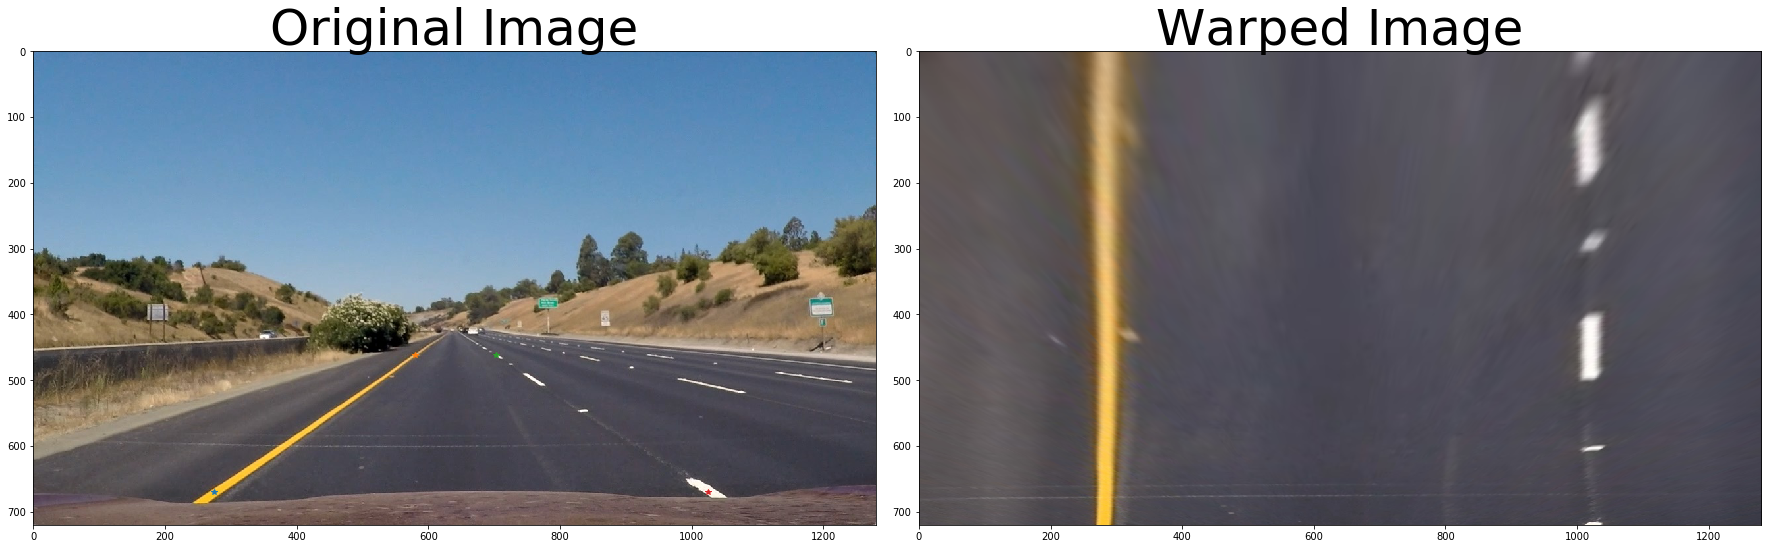

In [114]:
# use mpimg since cv2 uses BGR instead of RGB, so when an BGR image is shown on plt, it looks weird
image1 = mpimg.imread('test_images/straight_lines1.jpg')

# got src from Mac preview
# https://apple.stackexchange.com/questions/65162/retrieve-image-coordinates-at-mouse-cursor-in-preview-app
src = np.float32([[275,669],[580,461],[703,461],[1025,669]])
dst = np.float32([[275,720],[280,100],[1020,100],[1025,720]])

warped_image1, M = warper(image1, cameraMatrix, distCoeffs, src, dst)

print("image1 shape: ", image1.shape)
print("warped_image1 shape: ", warped_image1.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.plot(275,669,'*')
ax1.plot(580,461,'*')
ax1.plot(703,461,'*')
ax1.plot(1025,669,'*')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image1)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)